In [1]:
import numpy as np
import cv2
import operator
from matplotlib import pyplot as plt
import sys
import itertools
import os

#Scripts para leer y procesar imagen
sys.path.insert(0, '../Golden Master (AS IS)')
import readImage
import preProcessing as pP
import sorts as srt
import perspective as pPe
import indAnalysis as inA
import writeImage2

Im happy...


In [2]:
#Image folders
IMG_FOLDER = "../Imagenes/"
XM_FOLDER = "../Imagenes XM/" 
base_folder = os.path.dirname(os.path.dirname(os.getcwd()))
IMG_FOLDER_ABS_PATH = base_folder +  "\\Imagenes\\"
XM_FOLDER_ABS_PATH = base_folder + "\\Imagenes XM\\" 
XM_FOLDER_ABS_PATH

'C:\\Users\\LaptopUser\\jupyterNotebook\\Imagenes XM\\'

In [3]:
#Parameters for finding Individual XM-Markers 
qr = ['601170500100157']
count = [[1,2]]
ext = ".png"
local = True 
XM_PER_DEVICE = 6
xm_ids = [ str(id).zfill(2) for id in range(0,XM_PER_DEVICE)]

In [4]:
#XM-Markers filenames (Version 1)
if local:
    for qr_idx, each_qr in enumerate(qr):
        counters = [ str(x).zfill(3) for x in count[qr_idx] ]
        counters_tiled = [ x for x in counters for y in range(0,XM_PER_DEVICE)]
        xm_ids_tiled = np.tile(xm_ids, len(counters))
        qrs = [each_qr] * (len(counters) * XM_PER_DEVICE)
        filenames = [ "_".join(x) + ext for x in zip(qrs,counters_tiled, xm_ids_tiled) ]
        qr_filenames = list(zip(qrs,filenames))
filenames

['601170500100157_001_00.png',
 '601170500100157_001_01.png',
 '601170500100157_001_02.png',
 '601170500100157_001_03.png',
 '601170500100157_001_04.png',
 '601170500100157_001_05.png',
 '601170500100157_002_00.png',
 '601170500100157_002_01.png',
 '601170500100157_002_02.png',
 '601170500100157_002_03.png',
 '601170500100157_002_04.png',
 '601170500100157_002_05.png']

In [26]:
#Read XM-markers 
input = []
input_filenames = []
input_filenames_with_xms_ids = []
xms_found = []
if local:
  for each_filename in filenames:
    img = readImage.readLocal( XM_FOLDER_ABS_PATH + each_filename)
    filename_ids = each_filename.split("_")
    qr_from_filename = filename_ids[0] + "_" + filename_ids[1]
    xm_id_from_fn, xt = os.path.splitext(filename_ids[2])
    if img is not None and img.size != 0:
      input.append(img)
      input_filenames.append(qr_from_filename)
      input_filenames_with_xms_ids.append(qr_from_filename + '_' + xm_id_from_fn)  
      xms_found.append(each_filename)
  input_with_ids = list(zip(input_filenames, input))
len(input_with_ids)

6

In [31]:
#Sanity check
number_of_counters = len([ x for counters_per_qr in count for x in counters_per_qr])
if len(qr) * number_of_counters * XM_PER_DEVICE == len(input):
    print("I'm happy...")
else:
    print("Upps!!! Some images not found, proceeding with what we got...")
    print("Expected : " + str(len(qr) * number_of_counters * XM_PER_DEVICE))
num_images = len(input)
print("Number of XM-Markers found : " + str(num_images))
print("XM-Markers filenames found:") 
xms_found

Upps!!! Some images not found, proceeding with what we got...
Expected : 12
Number of XM-Markers found : 6
XM-Markers filenames found:


['601170500100157_001_00.png',
 '601170500100157_001_01.png',
 '601170500100157_001_02.png',
 '601170500100157_001_03.png',
 '601170500100157_001_04.png',
 '601170500100157_001_05.png']

601170500100157_001


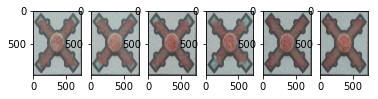

In [7]:
#show XM-Markes
rows = len(input) // XM_PER_DEVICE
for i,img in enumerate(input):
    if i % XM_PER_DEVICE == 0:
        print(input_with_ids[i][0])
    plt.subplot(rows,XM_PER_DEVICE, i % XM_PER_DEVICE + 1), plt.imshow(img)
ax = plt.gca()
plt.show()

In [8]:
#Image Quality Checkup 1 - RGB Analysis - Red vs White/Blue

# RGB values for Red Blood Color Pallete:
#       187,10,30 (Dark Red Blood)
#       131,3,3 (http://www.color-hex.com/color-palette/2326)
#       201,4,66 (http://rgb.to/color/2839/blood-orange)
#       250,54,53 (http://rgb.to/color/2843/blood-orange)
#       248, 118, 66 (http://rgb.to/color/2842/blood-orange)
# Hipotesis 1: The more green the more yellow/orange
# Hipotesis 2: The more blue the more cyan/magenta

#Split into BGR components
#  OpenCV split functions assumes BGR format i.e. b = [:,:,0], g = [:,:,1], r = [:,:,2] 
img = input[0]
print(img.shape)
b,g,r = cv2.split(img)

(970L, 728L, 3L)


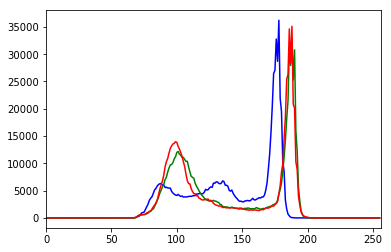

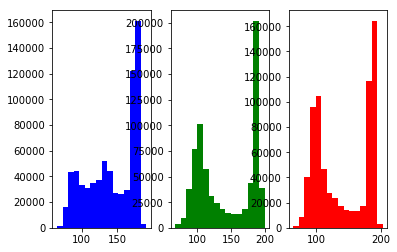

In [9]:
#Intensity histogram by color (assumes BGR format)
# http://docs.opencv.org/trunk/d1/db7/tutorial_py_histogram_begins.html
show_color_hist_1 = True
show_color_hist_2 = True
if show_color_hist_1:
  color = ('b','g','r')
  for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
  plt.show()
if show_color_hist_2:
  plt.subplot(131),  
  plt.hist(b.flatten(), bins = 16, color = ['blue'])  
  plt.subplot(132),  
  plt.hist(g.flatten(), bins = 16, color = ['green'])
  plt.subplot(133),  
  plt.hist(r.flatten(), bins = 16, color = ['red'])
  plt.show()

In [28]:
# Calculate gradient v1
g_list = []
for img in input:
    g = {}
    g['gx'] = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
    g['gy'] = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)
# Magnitude and direction ( in degrees ) 
    g['mag'], g['angle'] = cv2.cartToPolar(g['gx'], g['gy'], angleInDegrees=True)
    g_list.append(g)
g_list_with_ids = list(zip(input_filenames_with_xms_ids, g_list))
len(g_list_with_ids)

6

601170500100157_001_00
601170500100157_001_01
601170500100157_001_02
601170500100157_001_03
601170500100157_001_04
601170500100157_001_05


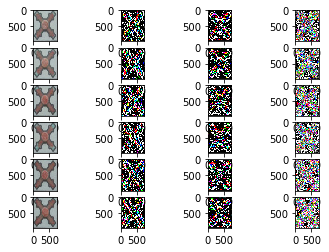

In [29]:
j = len(g_list)
i = 0
for fn,g in g_list_with_ids:
    print(fn)
    plt.subplot(j,4, (4 * i) + 1), plt.imshow(input[i])
    plt.subplot(j,4, (4 * i) + 2), plt.imshow(g['gx'])
    plt.subplot(j,4, (4 * i) + 3), plt.imshow(g['gy'])
    plt.subplot(j,4, (4 * i) + 4), plt.imshow(g['mag'])
    i+=1
plt.show()